## Abstract

Companies seeking public funding partner up with investment banks who bear the responsibility of facilitating the private bidding process. The private company sells all shares to the investment bank who in turn take the outstanding shares public. Because the investment banks take on the risk of the shares, many hypothesize that the IPO price tends to be undervalued so that the bank is not left with excess stock (read: risk).

Is this myth true? Do IPOs truly tend to be underpriced? If so, is there a pattern that can be identified? Could short term underpricing really just be long-term overvaluation in disguise?

These questions will be explored in this report.

Credits:

-Yusef '18 (Project)

-Owen '18 (Help with multiprocessing code)

## Loading Modules:

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import re
plt.style.use('ggplot')
import matplotlib
%matplotlib inline

## Loading Dataset:

The data used in this report was originally taken from Google finance.

The multiprocessing code used to obtain the original Google finance data can be found here: http://puu.sh/oKMeh/1e7ee7d056.docx

Note that since the code takes a very long time to run (more than 15,000 calls, necessity of a VPN, etc) the code was ran ahead of time and the data was uploaded to a personal filehosting website. This is what PANDAS will read.

In [49]:
# Download the data file from `puu.sh` and save it locally under `file_name`:
url = "http://puu.sh/oBCfW/c006093339.xlsx" # Script was ran ahead of time and uploaded onto this website. Random sample.
file_name = "./IPO_Expanded_Multiprocessing_d.xlsx"

req = requests.get(url)
file = open(file_name, 'wb')
for chunk in req.iter_content(100000):
    file.write(chunk)
file.close()

In [50]:
my_data = pd.read_excel(file_name,sheetname="Nasdaq_IPO_Expanded_Multiproces")

In [51]:
my_data.head(3)

,Company Name,Symbol,Market,Initial Price,Initial Shares,Offer Amount,IPO Date,Current Price,Industry,Sector,Current Beta,First Day Open Price,First Day High Price,First Day Low Price,First Day Close Price,First Day Volume,Thirty Days Later Date,Thirty Days Later Close Price,One Year Later Date,One Year Later Close Price
0,SECUREWORKS CORP,SCWX,NASDAQ,14,8000000,112000000,2016-04-22,13.33,IT Services & Consulting - NEC,Technology,NaN,13.89,14.6,13.4,14.00,7986552,2016-04-29,13.33,2016-04-04,13.33
1,"AMERICAN RENAL ASSOCIATES HOLDINGS, INC.",ARA,New York Stock Exchange,22,7500000,165000000,2016-04-21,28.12,Healthcare Facilities & Services - NEC,Healthcare,NaN,26.5,27.4,26,26.50,4979102,2016-04-28,27.50,2016-04-04,27.50
2,MGM GROWTH PROPERTIES LLC,MGP,New York Stock Exchange,21,50000000,1050000000,2016-04-20,22.07,Hospitality REITs,Financials,NaN,22.75,22.88,21.92,22.01,29591485,2016-04-28,22.26,2016-04-04,22.26


## Cleaning Data

In [52]:
df = my_data.copy()
## These symbols were not available 
df = df[df.Symbol != "GAV'U"]
df = df[df.Symbol != "AGR'A"]
df = df[df.Symbol != "TAP'A"]
df = df[df.Symbol != "PED'U"]

df.shape

(4846, 20)

In [53]:
df["First Day Open Price"] = df["First Day Open Price"].replace("-",np.nan).astype('float')
df= df[df["First Day Open Price"]<200]
df.shape

(2171, 20)

In [54]:
df.Sector.replace(to_replace="&amp;",value="",regex=True,inplace=True) 

## Calculating New Parameters

In [55]:
df["Day_Closing"] = 100 * (df["First Day Open Price"] - df["First Day Close Price"])/(df["First Day Open Price"])
df["Day30_closing"] = 100 *(df["First Day Open Price"] - df["Thirty Days Later Close Price"])/(df["First Day Open Price"])
df["Current_closing"] = 100 * (df["First Day Open Price"] - df["Current Price"])/(df["First Day Open Price"])

a = {}
b = []
for i in df.Symbol:
    try:
        x = Share(i).get_price()
        if x == None:
            b.append(i)
        else:
            a[i] = x
    except:
        print(i)

## Data Visualization

#### First, let's take a look at some general IPO information.

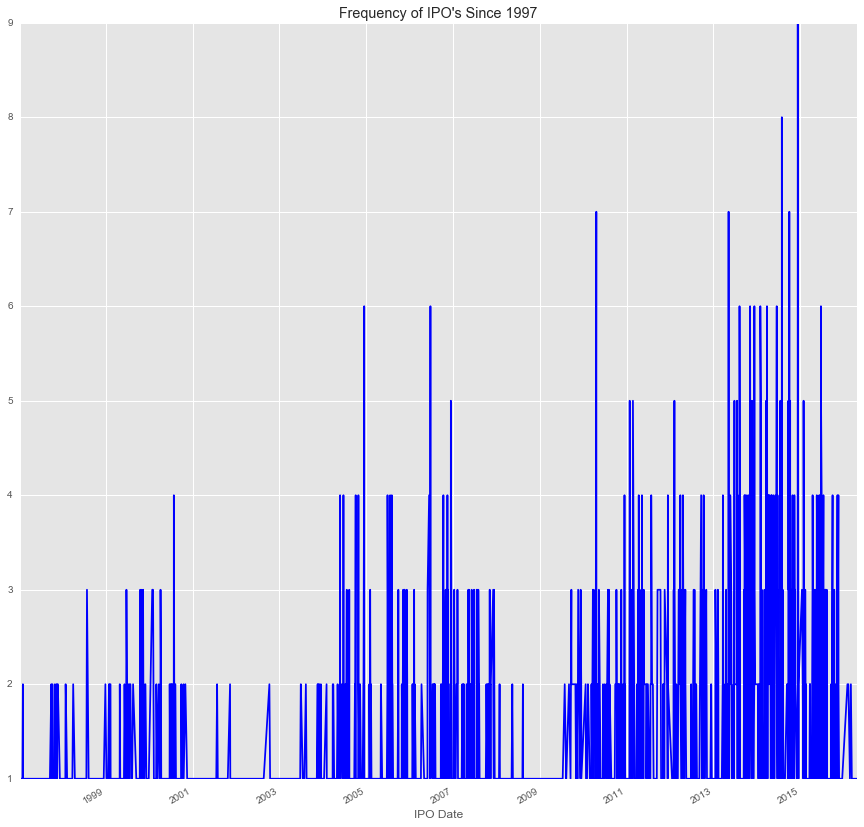

In [56]:
plt.figure();
df.Symbol.groupby(df["IPO Date"]).count().plot(title = "Frequency of IPO's Since 1997",
               figsize=(15,15),color="b")

#### Notice the lack of IPOs following the popping of economic bubbles (dot-com, asset-backed securities). This can be visualized nicely with a chart. Notice where dy/dx approaches 0. 

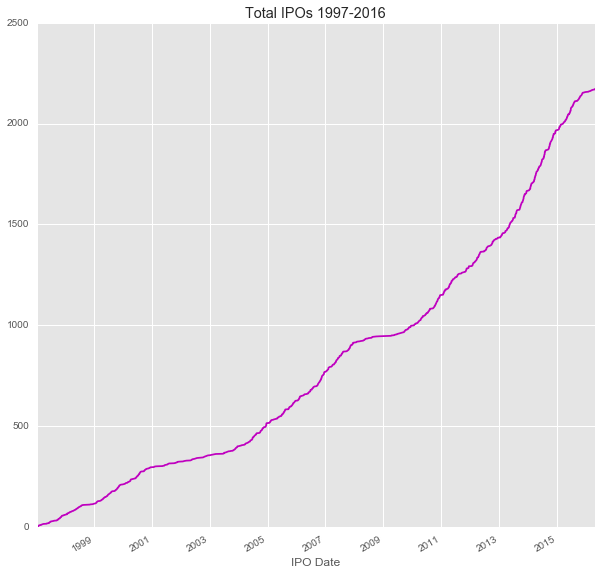

In [57]:
df_graph2 = df["First Day Close Price"].groupby(df["IPO Date"]).count()
df_graph2 = pd.DataFrame(df_graph2)
df_graph2['index1'] = df_graph2.index
#df_graph2 = df_graph2.reset_index(drop = True)
df_graph2.columns = ["Number","IPO Date"]
df_graph2["Number"].cumsum().plot(title = "Total IPOs 1997-2016", figsize = (10,10), color="m")

#### Yikes, is that another plateau coming in 2016? Let's hope not. Anyways, let's take a look at the most common sectors for IPOs. A random sample of around 600 stocks were used.

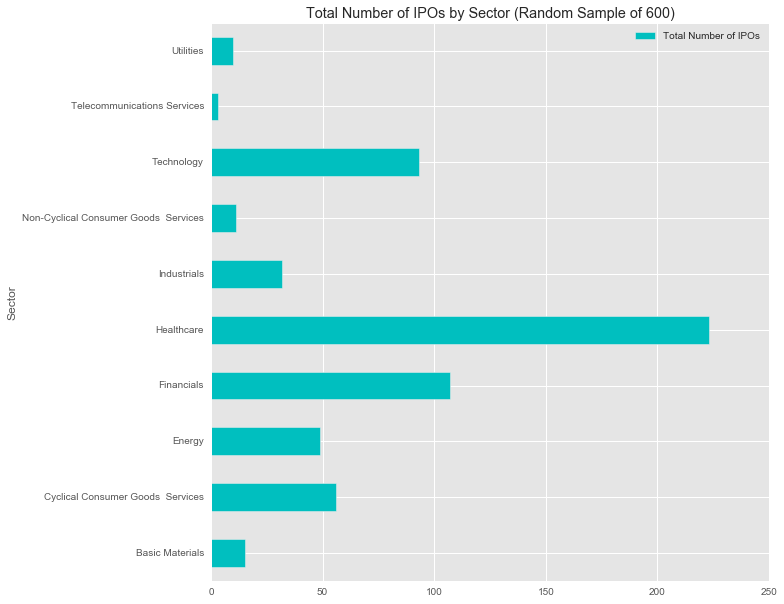

In [58]:
df_graph3 = df.groupby(["Sector"]).count()

df_graph3 = df_graph3.reset_index()
df_graph3.index = df_graph3["Sector"]

df_graph3 = df_graph3[["Symbol"]]
df_graph3.columns = ["Total Number of IPOs"]
df_graph3.plot(kind="barh",title = "Total Number of IPOs by Sector (Random Sample of 600)", figsize = (10,10),color="c")

#### Somewhat shockingly, healthcare is the sector that dominates IPOs the most— and by a large margin. 

#### Now that we have some basic IPO info, let's visualize some of the underpricing. 

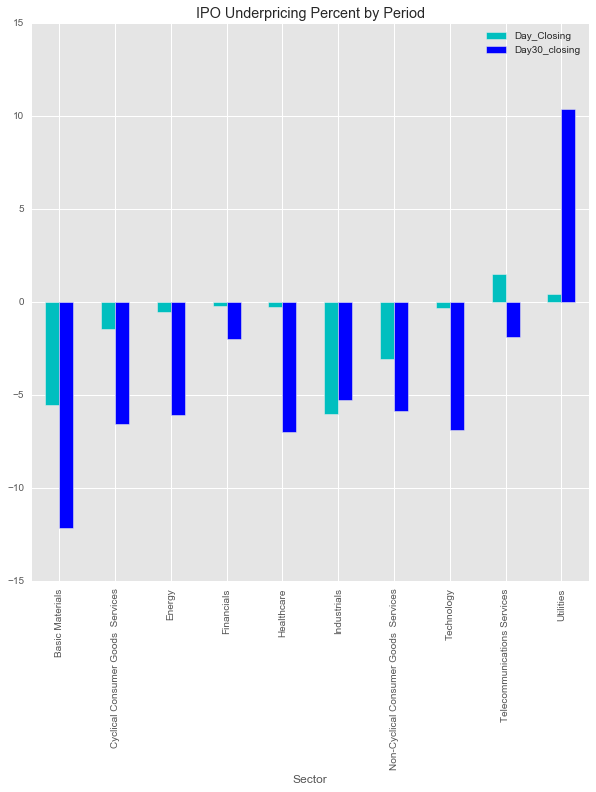

In [59]:
my_colors = 'cbmg'
df_graph1 = df[["Day_Closing","Day30_closing",]].groupby(df["Sector"]).mean()
df_graph1['index1'] = df_graph1.index
df_graph1.reset_index(drop=True)
df_graph1.plot(kind = "bar",title = "IPO Underpricing Percent by Period",
               figsize=(10,10), subplots=False,legend = True,color=my_colors)

#### This bar chart graphs the % of underpricing using the columns generated in the "Calculating New Paramaters" section.

#### Almost every sector experiences short-term underpricing. The exceptions for this are Telecommunications Services, which experiences overvaluation in the hyper-short term (first day), and Utilities, which is glaringly overvalued. 

#### Finally, let's take a look at the long term pricing to see if these sectors are experiencing underpricing or overvaluation. 

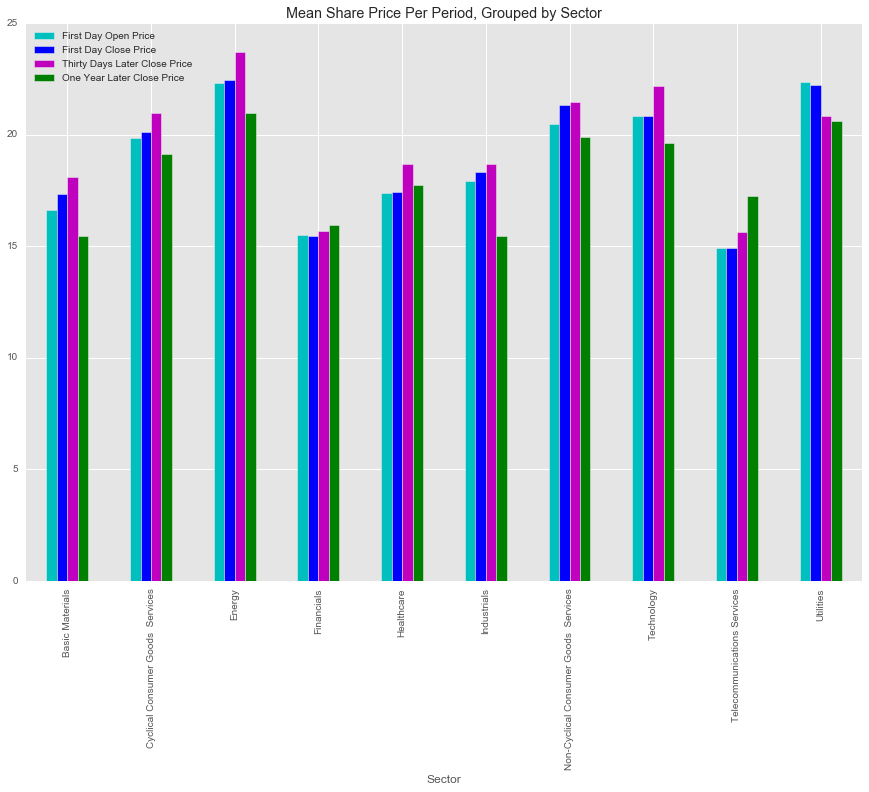

In [60]:
df[["First Day Open Price","First Day Close Price",'Thirty Days Later Close Price',
    'One Year Later Close Price']].groupby(df["Sector"]).mean().plot(kind = "bar",
                                                                     legend= True,
                                                                     figsize=(15,10),
                                                                     title="Mean Share Price Per Period, Grouped by Sector",
                                                                     color=my_colors
                                                                     )

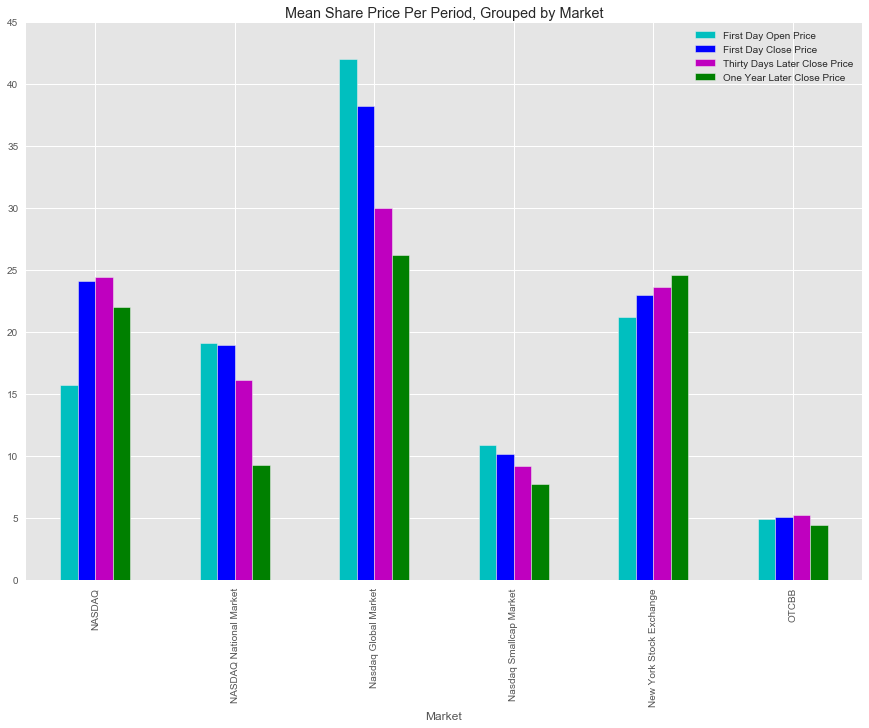

In [61]:
df[["First Day Open Price","First Day Close Price",'Thirty Days Later Close Price',
    'One Year Later Close Price']].groupby(df["Market"]).mean().drop(['American Stock Exchange'], axis=0).plot(kind = "bar",
                                                                     legend= True,
                                                                     figsize=(15,10),
                                                                     title="Mean Share Price Per Period, Grouped by Market",
                                                                     color=my_colors
                                                                     )

#### These two bar chart graph the average share price, grouped first by sector then by market, at First Day open, First Day close, Thirty Days Later close, and One Year Later close. 

#### As mentioned earlier, most sectors experience underpricing, except for Utilities which is clearly experiencing overvaluation. However, half of the sectors have One Year Later prices that are significantly less than the First Day Open Price, suggesting that overvaluation of IPOs is a widespread issue. 

#### Perhaps it is less of a case of investment banks underpricing the IPOs, but rather a case of investment banks selling the companies well and engendering overvaluation. 

#### For individual investors, this data can be very useful. In summary, investing in IPOs on opening day is almost always worth it, but some sectors pay off better than others and the Utilities sector should be avoided at all costs. The IPO stocks should not be held longer than thirty days, as the majority of stocks tend to dip below the opening price after only one year. Also, the market where the IPO is announced is important: investors should target IPOs on NASDAQ as the mean share price on that market goes up by nearly 66% on the first day. 

#### I hope you enjoyed my project and learned more about IPOs!

In [62]:
print("FIN")

FIN
